In [1]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

In [2]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import math as mt
import warnings

# 한글출력
matplotlib.rc('font', family='AppleGothic')
plt.rcParams['axes.unicode_minus'] = False
warnings.filterwarnings(action='ignore') 

from src import crs, PublicPredictor
from src.dbc import utils
from IPython.display import clear_output

In [3]:
# 1. load_excel
data_path = "data/apt_1.xlsx"
xlsx = pd.read_excel(data_path, header=None,
                     skiprows=2, engine="openpyxl")

# 2. data preprocessing
p, m = crs.utils.data_preprocessing(xlsx)

m.set_index("month", inplace=True)

# 3. data init
_month = 1

month_df = pd.DataFrame(m.loc[_month])
month_df.reset_index(inplace=True)

month_df.columns = ['name', 'usage (kWh)']

PUBLIC_PERCENTAGE = 30
APT = crs.utils.get_APT(month_df, PUBLIC_PERCENTAGE)

calc = crs.models.ManagementOffice(
        month=_month,
        households=month_df,
        APT=APT,
        contract="단일계약"
    )
apt = calc.apart

In [4]:
m_15 = utils.data_preprocessing(xlsx)

df = utils.dimension_reduction(m_15)
m_60 = df.copy()

m_60.head()

m_60_1 = m_60[m_60.index.month == 1].copy()
m_60_1.head()

,아파트1-104-1206,아파트1-104-303,아파트1-104-1307,아파트1-104-1208,아파트1-104-408,아파트1-104-203,아파트1-103-1402,아파트1-103-402,아파트1-103-1201,아파트1-103-801,...,아파트1-102-901,아파트1-103-1905,아파트1-103-503,아파트1-103-1504,아파트1-103-606,아파트1-103-903,아파트1-103-1106,아파트1-103-705,아파트1-103-1505,아파트1-103-406
2019-01-01 00:00:00,0.033,0.000,0.034,0.037,0.062,0.322,0.240,0.295,0.373,0.243,...,0.534,0.188,0.400,0.318,0.420,0.626,0.484,0.289,0.305,0.652
2019-01-01 01:00:00,0.048,0.000,0.033,0.037,0.063,0.185,0.257,0.397,0.257,0.228,...,0.396,0.434,0.355,0.250,0.465,0.409,0.459,0.336,0.332,0.557
2019-01-01 02:00:00,0.032,0.000,0.039,0.036,0.062,0.175,0.384,0.353,0.123,0.141,...,0.194,0.337,0.379,0.274,0.326,0.307,0.405,0.382,0.311,0.491
2019-01-01 03:00:00,0.033,0.000,0.039,0.037,0.062,0.167,0.276,0.488,0.142,0.159,...,0.286,0.263,0.375,0.264,0.336,0.345,0.298,0.291,0.261,0.511
2019-01-01 04:00:00,0.032,0.001,0.033,0.037,0.063,0.197,0.266,0.278,0.190,0.227,...,0.275,0.245,0.310,0.423,0.360,0.364,0.212,0.347,0.294,0.507


이상패턴 조정 확인 True


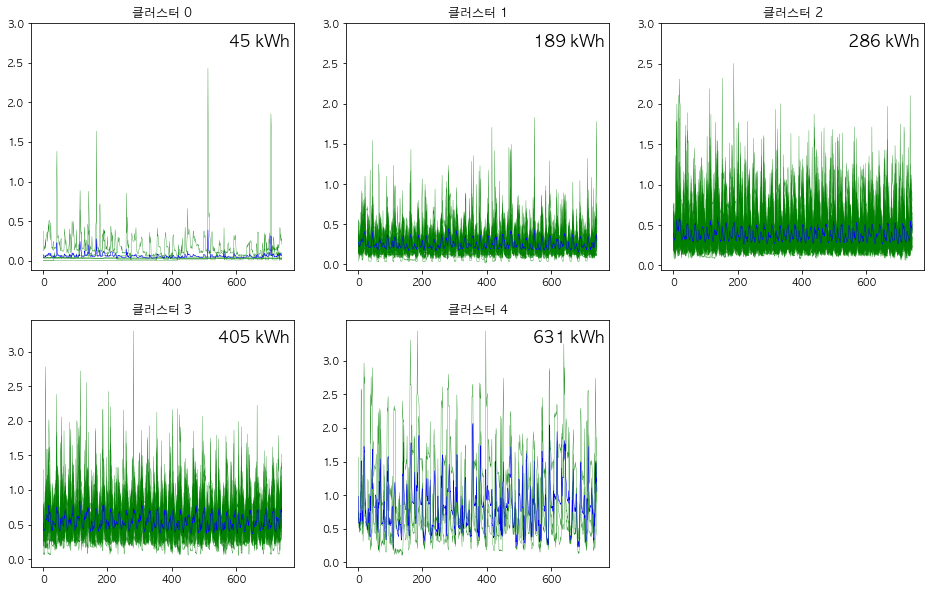

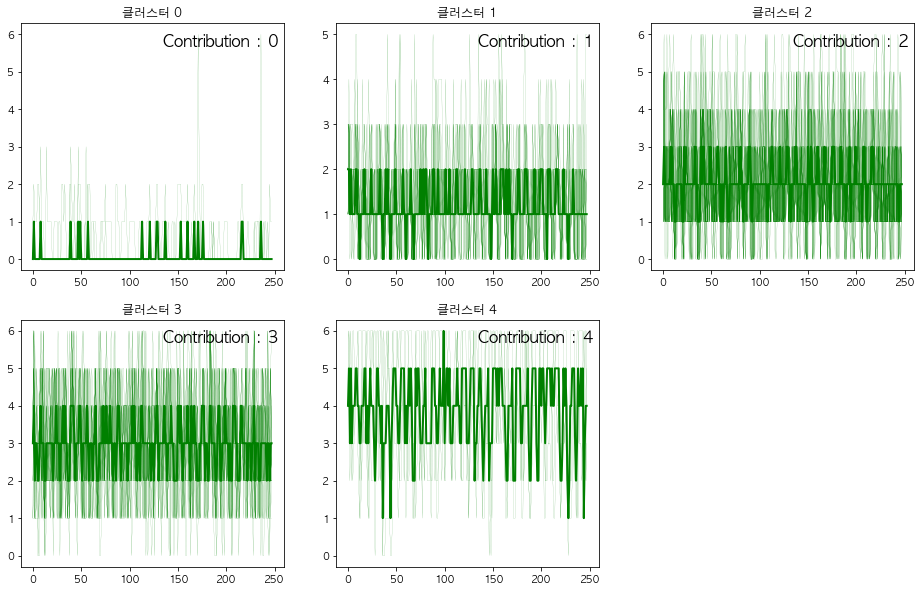

In [159]:
from src import SavingFeedback

sf = SavingFeedback(xlsx, _type="tdkmeans")

sf.select_month(1)
sf.kmeans_run()
sf.adjust_anomaly()

anomaly = sf.check_anomaly()
clear_output(wait=True)
print("이상패턴 조정 확인", len(anomaly) == 0)

sf.kmeans.draw_plot()
sf.kmeans.draw_cont_plot()

In [201]:
sf.time_based_grouping(time_size)
sf.kmeans.set_time_cont_table()

sf.feedback()
sf.result()

time_group = sf.new_group.copy()
time_group.head()

print("절약",round(time_group['usage (kWh)'].mean()))

# 의미 있는 피드백이 진행되었다는 거임
sf.recovery()

og_pat = sf.datas.values.T
rec_pat = sf.recoveries
err = (og_pat - rec_pat)

print(og_pat.shape, rec_pat.shape)
print("최소 오차", err[err != 0].min())

절약 221
(108, 744) (108, 744)
최소 오차 0.041999999999999996


(108, 744) (108, 744)
최소 오차 0.041999999999999996


In [195]:
month = 1

before_month_df = month_df[['name', 'usage (kWh)']].copy()
after_month_df = time_group[['name', 'usage (kWh)']].copy()
house_count = len(before_month_df)

PUBLIC_PERCENTAGE = 30
APT = crs.utils.get_APT(month_df, PUBLIC_PERCENTAGE)
public_kWh = APT - before_month_df['usage (kWh)'].sum()
before_calc = crs.models.ManagementOffice(
        month=month,
        households=before_month_df,
        APT=APT,
        contract="단일계약"
    )

after_APT = after_month_df['usage (kWh)'].sum() + public_kWh
after_calc = crs.models.ManagementOffice(
        month=month,
        households=after_month_df,
        APT=after_APT,
        contract="단일계약"
    )

compare_df = pd.DataFrame()
compare_df.index = ['before', 'after']
compare_df['APT 평균 사용량'] = [before_calc.apart.kwh, after_calc.apart.kwh]
compare_df['세대부 평균 사용량'] = [round(before_month_df['usage (kWh)'].mean()),
                           round(after_month_df['usage (kWh)'].mean())]
compare_df['공용부 평균 사용량'] = [
    round(public_kWh / house_count),
    round(public_kWh / house_count)
]

compare_df['아파트 전체 요금'] = [
    before_calc.bill,
    after_calc.bill
]
compare_df['세대부 전체 요금'] = [
    before_calc.bill - before_calc.public_bill,
    after_calc.bill - after_calc.public_bill
]
compare_df['공용부 요금'] = [
    before_calc.public_bill,
    after_calc.public_bill
]

compare_df.loc['error'] = compare_df.loc['before'] - compare_df.loc['after']
compare_df

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [125]:
sf.kmeans.target_cluster_cont_

array([[0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 2., 1., 1., 1., 1., 1., 1.],
       [2., 2., 2., 2., 2., 2., 2., 2.],
       [3., 3., 3., 3., 3., 3., 3., 3.],
       [4., 5., 4., 3., 3., 3., 4., 4.]])

In [144]:
target_house = sf.group[sf.group['name'] == "아파트1-103-1905"]
target_pattern = sf.datas["아파트1-103-1905"].values
time_group, mean_time_group = sf.time_grouping(
    target_pattern, sf.time_size)

label = target_house['label'].values[0]

In [151]:
_now = (sf.clusters_[label][1].mean(axis=1) *
        1000).astype(np.float).round() / 1000
_prev = (sf.clusters_[label - 1][1].mean(axis=1)
         * 1000).astype(np.float).round() / 1000
_target = (mean_time_group.mean(axis=1) *
           1000).astype(np.float).round() / 1000

_now_cont = sf.kmeans.target_cluster_cont_[label]
_prev_cont = sf.kmeans.target_cluster_cont_[label - 1]
_target_cont = sf.kmeans.target_cont_[
                    sf.datas.columns == "아파트1-103-1905"
                ]

In [153]:
now_saving_point = np.where(_target_cont > _now_cont)[0]
prev_saving_point = np.where(_target_cont > _prev_cont)[0]
prev_saving_point = prev_saving_point[~np.isin(
    prev_saving_point, now_saving_point)]

In [154]:
err = np.zeros(len(time_group))
err[now_saving_point] = _target[now_saving_point] - _now[now_saving_point]
err[prev_saving_point] = _target[prev_saving_point] - _prev[prev_saving_point]

In [157]:
print("모든 사용량이 피드백 되었나요?", sum(neg_mem) <= 0)
print("실천 최대 기대값 {}kWh \n".format(round(sims.sum())))

모든 사용량이 피드백 되었나요? True
실천 최대 기대값 331kWh 



In [202]:
month = 1

before_month_df = month_df[['name', 'usage (kWh)']].copy()
after_month_df = time_group[['name', 'usage (kWh)']].copy()
house_count = len(before_month_df)

PUBLIC_PERCENTAGE = 30
APT = crs.utils.get_APT(month_df, PUBLIC_PERCENTAGE)
public_kWh = APT - before_month_df['usage (kWh)'].sum()
before_calc = crs.models.ManagementOffice(
        month=month,
        households=before_month_df,
        APT=APT,
        contract="단일계약"
    )

after_APT = after_month_df['usage (kWh)'].sum() + public_kWh
after_calc = crs.models.ManagementOffice(
        month=month,
        households=after_month_df,
        APT=after_APT,
        contract="단일계약"
    )

compare_df = pd.DataFrame()
compare_df.index = ['before', 'after']
compare_df['APT 평균 사용량'] = [before_calc.apart.kwh, after_calc.apart.kwh]
compare_df['세대부 평균 사용량'] = [round(before_month_df['usage (kWh)'].mean()),
                           round(after_month_df['usage (kWh)'].mean())]
compare_df['공용부 평균 사용량'] = [
    round(public_kWh / house_count),
    round(public_kWh / house_count)
]

compare_df['아파트 전체 요금'] = [
    before_calc.bill,
    after_calc.bill
]
compare_df['세대부 전체 요금'] = [
    before_calc.bill - before_calc.public_bill,
    after_calc.bill - after_calc.public_bill
]
compare_df['공용부 요금'] = [
    before_calc.public_bill,
    after_calc.public_bill
]

compare_df.loc['error'] = compare_df.loc['before'] - compare_df.loc['after']
compare_df

,APT 평균 사용량,세대부 평균 사용량,공용부 평균 사용량,아파트 전체 요금,세대부 전체 요금,공용부 요금
before,411,288,123,6439540,3798980,2640560
after,345,221,123,4585930,2606630,1979300
error,66,67,0,1853610,1192350,661260


In [204]:
drawing = sf.draw_init()

현재 가구가 속해 있는 기여도 그룹의 이전 그룹


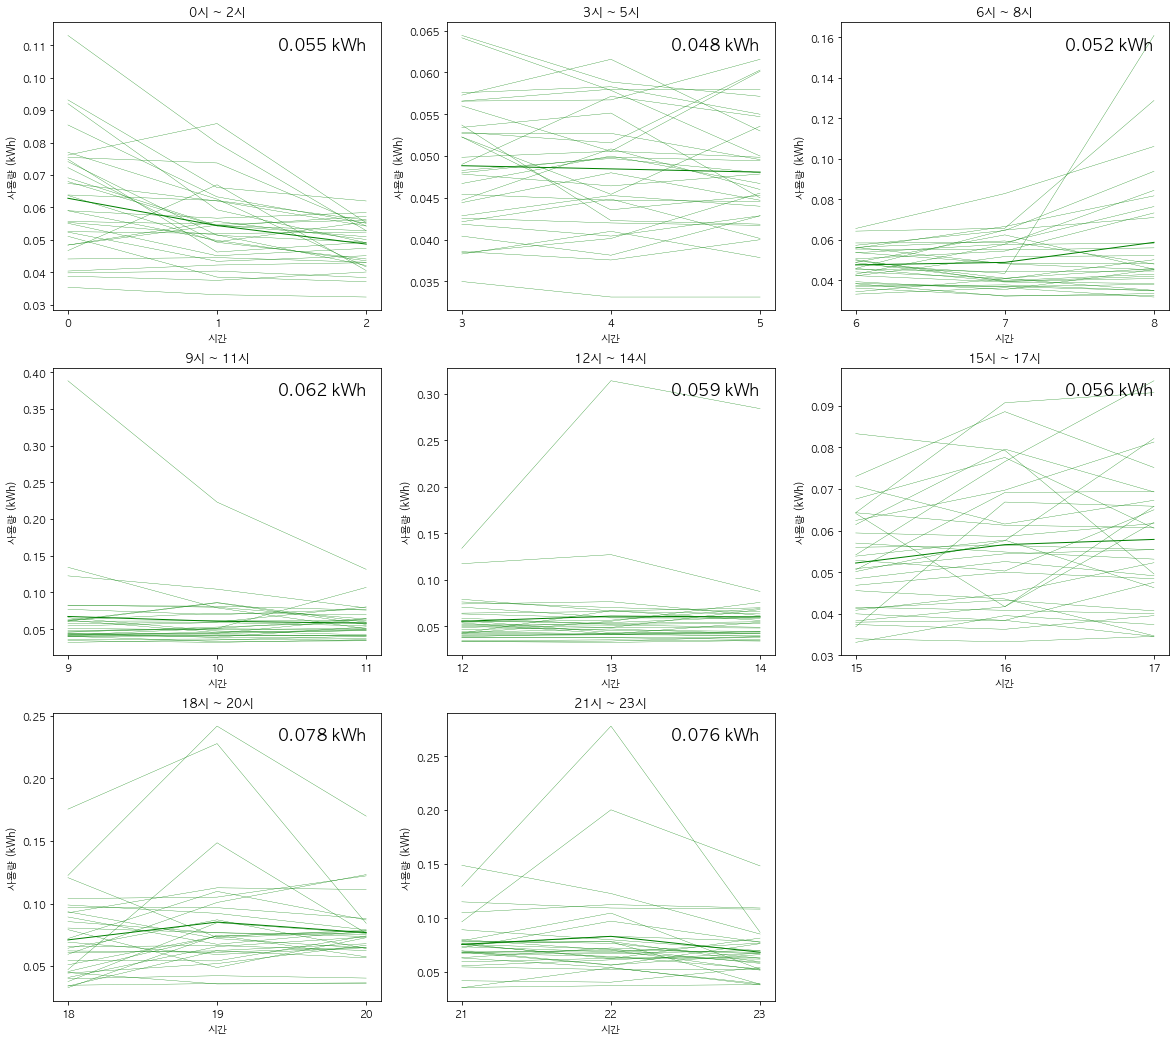

In [207]:
drawing.prev()

현재 가구가 속해 있는 기여도 1번 그룹


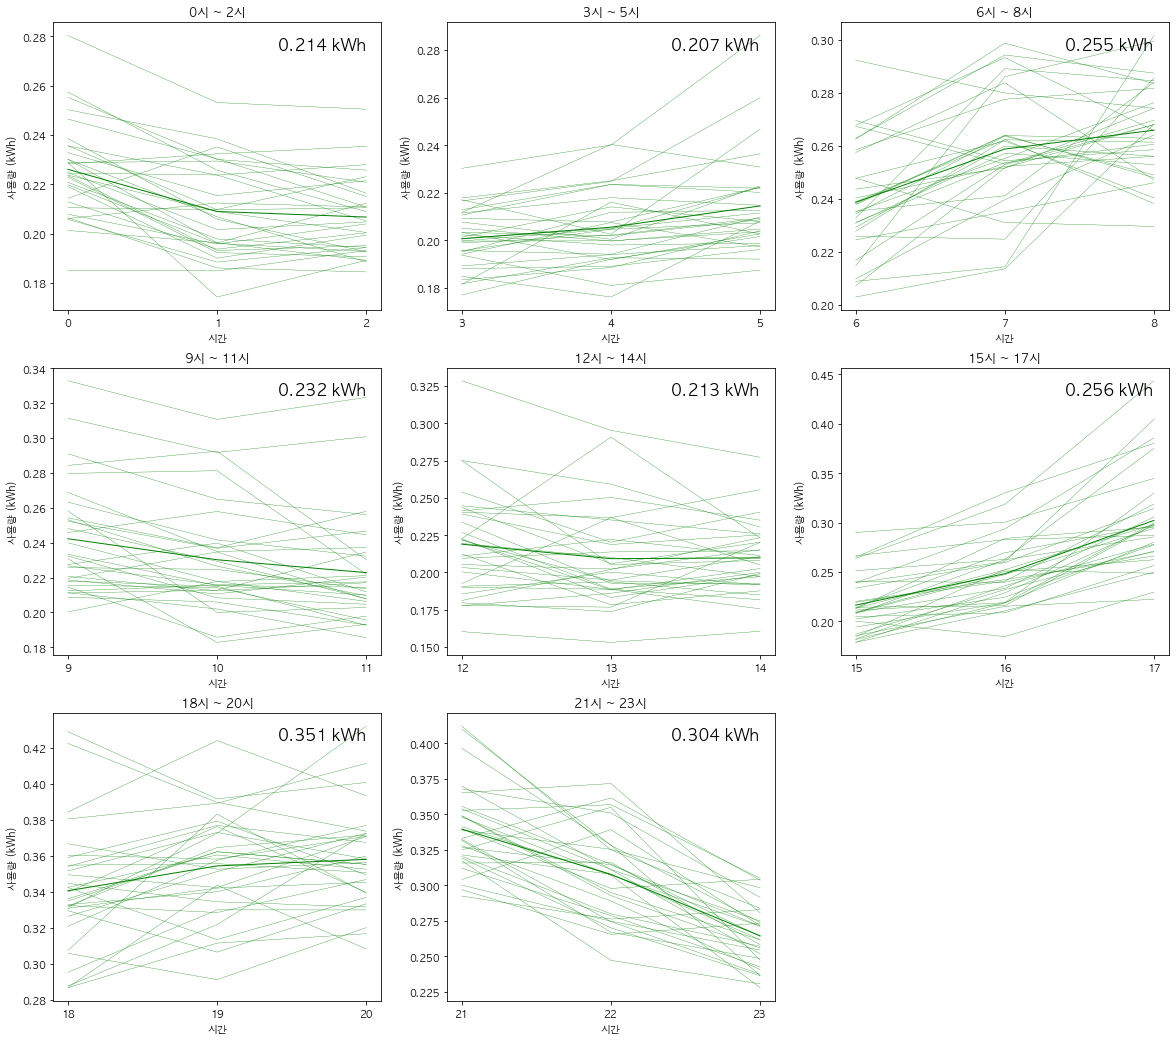

In [206]:
drawing.now()

가구 명 : 아파트1-103-602


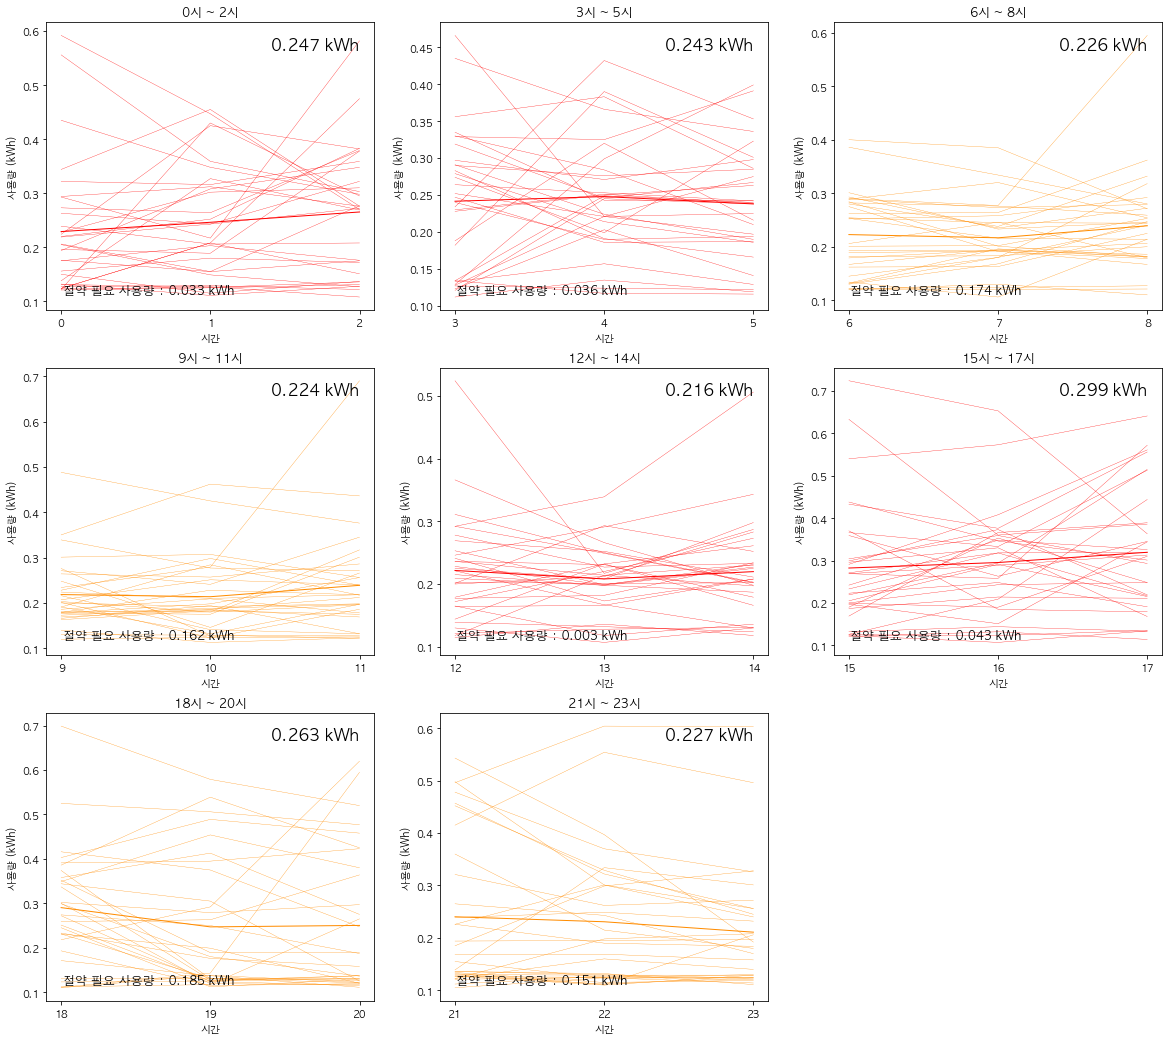

In [205]:
drawing.house()